# Image classifiers

In [1]:
# Imports to be used through the notebook

import torch 
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import time


import utils

In [2]:
import torch 

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Data (MNIST)

In [3]:
# We define a transformation to apply to the items of the dataset (that are, by default, in PIL image format). The standardization will help with training.

MEAN_MNIST = (0.1307,)
STD_MNIST = (0.3081,)

transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN_MNIST, STD_MNIST)])


trainset = torchvision.datasets.MNIST(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=True,
                                        download=True, transform=transform_mnist)

testset = torchvision.datasets.MNIST(root='C:\\Users\\PabloHueso\\OneDrive - CompoSistemas, S.L\\Documents\\Master\\M2\\ENAC\\Adversarial-attacks\\Datasets', train=False,
                                       download=True, transform=transform_mnist)


#trainset.__len__() # yields 60000
#trainset.__getitem__(0) # tuple (image, class); image is a tensor 1x28x28 and class is an int
#trainset.__getitem__(0)[0].shape #yields torch.Size([1, 28, 28])

In [4]:
# Trainloaders are dataset wrappers used to access them in a batched way. Of course this is very useful for NN training.
batch_size = 32

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print("Size train loader: ", len(trainloader), " | test loader: ", len(testloader))

Size train loader:  1875  | test loader:  313


In [5]:
batch = next(iter(trainloader)) # batches are lists of two tensors, one containing features and other labels.

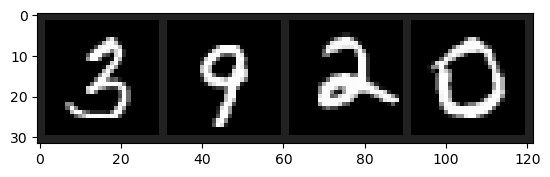

Labels:      3             9             2             0 

Image shape (number of channels, height, width): (1, 28, 28)


In [6]:
# functions to show an image
def imshow(img):
    img = img * STD_MNIST[0] + MEAN_MNIST[0]  # Proper unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')  # MNIST is grayscale + original tensor shape is (1,28,28) so  np.transpose(img, (1, 2, 0)) gets it to shape (28,28,1) 
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
images, labels = images[:4], labels[:4]

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('Labels:     ','             '.join(f'{labels[j]}' for j in range(4)), '\n')
print(f'Image shape (number of channels, height, width): {tuple(images[0].shape)}')

In [7]:
images.shape

torch.Size([4, 1, 28, 28])

## Load model


In [8]:
import archis
model = archis.SimpleCNN(input_channels=1, output_channels=10)
model.load_state_dict(torch.load('Models\MNISTsmall.pth'))
model.to(device)
model.eval()

SimpleCNN(
  (conv): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1690, out_features=10, bias=True)
)

## Example of attack

In [9]:
x_batch, y_batch = next(iter(trainloader)) #x_batch is of dimension [B, C, H, W] = [512, 1, 28, 28]. Elements of it (like x_batch[0]) are of dimension [C, H, W] = [1, 28, 28].
x_single = x_batch[0].unsqueeze(0)  # Add batch dimension back (shape: [1, C, H, W])


x_single = x_single.to(device)
output = model(x_single)

In [10]:
x_batch = x_batch.to(device)

In [11]:
import utils
x_adv_1 = utils.ocf_attack(model, x_single, attacked_class=2, nb_steps=1, total_budget=100)
x_adv_2 = utils.ocf_attack(model, x_single, attacked_class=2, nb_steps=10, total_budget=100)
x_adv_3 = utils.ocf_attack(model, x_single, attacked_class=2, nb_steps=30, total_budget=100)
x_adv_4 = utils.ocf_attack(model, x_single, attacked_class=2, nb_steps=100, total_budget=100)

In [12]:
x_adv_1 = x_adv_1.to('cpu')
x_adv_2 = x_adv_2.to('cpu')
x_adv_3 = x_adv_3.to('cpu')
x_adv_4 = x_adv_4.to('cpu')
x_single = x_single.to('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


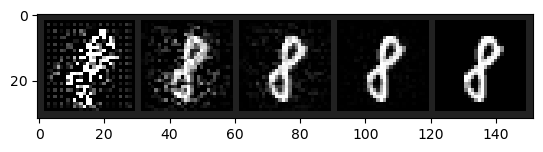

In [13]:
adversarial_examples = torch.cat((x_adv_1, x_adv_2, x_adv_3, x_adv_4, x_single), dim=0)
imshow(torchvision.utils.make_grid(adversarial_examples))

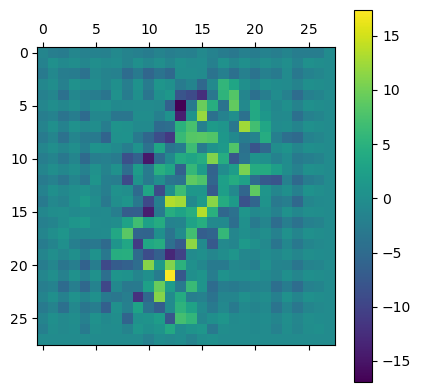

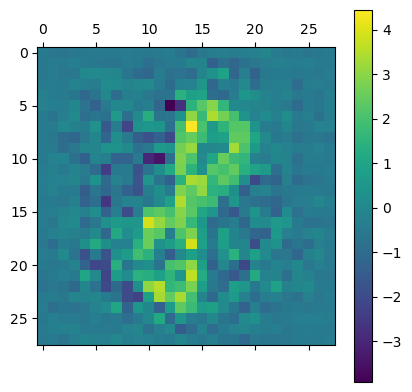

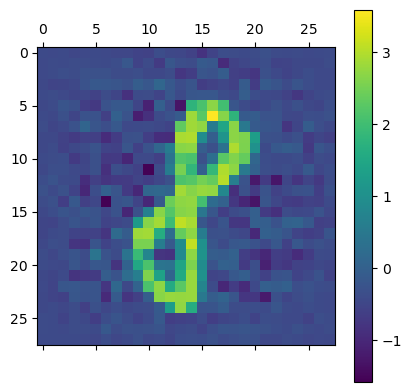

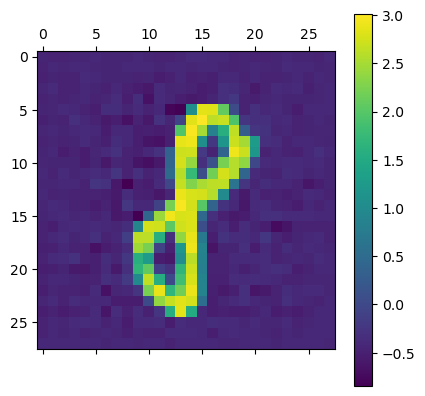

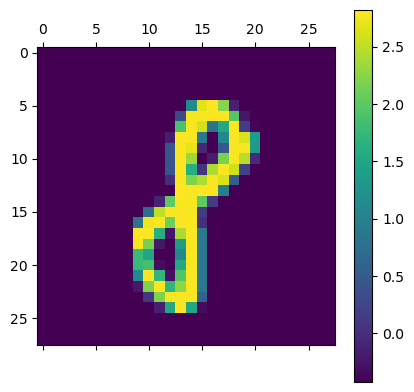

In [20]:
for i in range(adversarial_examples.shape[0]):
    v = plt.matshow(adversarial_examples.detach().numpy()[i].squeeze(0)) # Shaping each image to matrix form
    plt.colorbar(v)

In [14]:
x_adv_batch = utils.ocf_attack(model, x_batch, nb_steps=4, total_budget=20)

## Attack performance

In [25]:
import torch
from tqdm.auto import tqdm                # pip install tqdm if you don’t have it

# -----------------------------------------------------------
# 0.  Setup
# -----------------------------------------------------------
device = next(model.parameters()).device      # 'cuda:0' or 'cpu'

nb_step_grid      = range(1, 101, 10)             # 1 … 100
total_budget_grid = range(3, 11, 2)              # 3 … 10
n_settings        = len(nb_step_grid) * len(total_budget_grid)

n_images  = len(testloader.dataset)
n_classes = 10                                 # you said 10 classes

# -----------------------------------------------------------
# 1.  Pre‑allocate storage
# -----------------------------------------------------------
all_logits = torch.empty(
    len(nb_step_grid), len(total_budget_grid), n_images, n_classes,
    dtype=torch.float32, device=device
)
correct = torch.zeros(len(nb_step_grid), len(total_budget_grid),
                      dtype=torch.int32, device=device)
total   = torch.zeros_like(correct)

# -----------------------------------------------------------
# 2.  Main evaluation loop with progress
# -----------------------------------------------------------
with torch.no_grad():
    global_idx = 0

    # Outer bar: iterate once over the test set
    for batch_idx, (images, labels) in enumerate(
            tqdm(testloader, desc="Batches", position=0)):

        images, labels = images.to(device), labels.to(device)
        batch_size     = images.size(0)

        # Nested bars for the hyper‑parameter sweep
        for i_nb, nb_steps in enumerate(
                tqdm(nb_step_grid, desc="nb_steps", position=1, leave=False)):

            for j_tb, total_budget in enumerate(
                    tqdm(total_budget_grid, desc="budget", position=2, leave=False)):

                adv_images = utils.ocf_attack(model, images, attacked_class=2,
                                        nb_steps=nb_steps,
                                        total_budget=total_budget)

                logits = model(adv_images)

                # Store logits
                all_logits[i_nb, j_tb,
                           global_idx:global_idx + batch_size] = logits

                # Update accuracy counters
                preds = logits.argmax(dim=1)
                correct[i_nb, j_tb] += (preds == labels).sum().to(correct.dtype)
                total[i_nb,  j_tb]  += torch.tensor(batch_size, dtype=correct.dtype,
                                                    device=device)

        global_idx += batch_size

        # ---- quick console feedback every 10 batches ---------------------------
        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == len(testloader):
            print(f"Processed {global_idx}/{n_images} images "
                  f"({(100*global_idx/n_images):.1f} %)")

# -----------------------------------------------------------
# 3.  Compute accuracy
# -----------------------------------------------------------
accuracy = correct.float() / total
print("\nSweep finished!")
print("Accuracy grid shape:", accuracy.shape)    # should be (100, 8)


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

nb_steps:   0%|          | 0/10 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

budget:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 